My solution should:
1) Process a real or synthetic RGB image
2) Identify multiple objects/packages in the scene
3) For each package:
    * Determine the optimal surface point or region for a robotic pick
    * Compute the surface normal vector at that point
    * Represent the normal as a 2D or 3D arrow overlay on the image

First, I will use mobileSAM again for this application as the first part is clearly just a segmentation problem where I need to separate each package in the image to be able to treat them individually. For that, I can simply reuse code from the first challenge -- VLM.

In [53]:
import sys
import cv2
import numpy as np
import torch
import warnings
import matplotlib.pyplot as plt
import random

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

sys.path.append("../1_VLM_Scenario")
sys.path.append("../1_VLM_Scenario/mobilesam")
from mobilesam.mobile_sam.automatic_mask_generator import SamAutomaticMaskGenerator
from mobilesam.mobile_sam import sam_model_registry
from mobilesam.mobile_sam.predictor import SamPredictor

model_type = "vit_t"
model_path = "../1_VLM_Scenario/mobilesam/weights/mobile_sam.pt"
mobile_sam = sam_model_registry[model_type](checkpoint=model_path)

if torch.backends.mps.is_available():
    device = 'mps'
    print("Using MPS") # MACOS
elif torch.cuda.is_available():
    device = 'cuda'
    print("Using CUDA") # NVIDIA GPU
else:
    device = 'cpu'
    print("Using CPU") # a sad VM like this one

mobile_sam.to(device)
mobile_sam.eval()

mask_gen = SamAutomaticMaskGenerator(
    mobile_sam, # I modified the parameters slightly to improve package detection -- big objects where I don't need small details.
    points_per_side=32,
    pred_iou_thresh=0.92,
    stability_score_thresh=0.95,
    crop_n_layers=0,
    min_mask_region_area=5000,
)

Using CPU


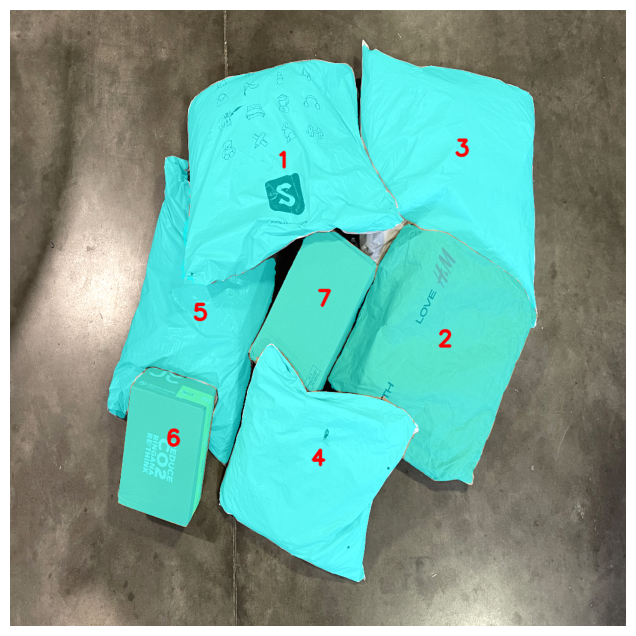

In [54]:
def get_area(mask): # More readable than lambda
    return mask['area']

image = cv2.imread("IMG_9102.jpeg")
"""
Resize image to fit model input size -- It's crucial! 
Otherwise, the VM even happened to crash!
"""
image = cv2.resize(image, (1024, 1024), interpolation=cv2.INTER_LINEAR)
image = cv2.convertScaleAbs(image, alpha=1.1, beta=2) # Simple contrast enhancement. I saw it helps with this application. Values are empirical.
all_masks = mask_gen.generate(image) # Let SAM do the magic
all_masks = sorted(all_masks, key=get_area, reverse=True)
"""
Packages usually lay around 20k to 120k pixels, so I filter them based on area. The stability score is also a good indicator of how reliable the mask is.
"""
packages = [m for m in all_masks if m['area'] > 20000 and m['area'] < 120000 and m['stability_score'] > 0.9]

canvas = image.copy()
alpha = 0.6

for i, mask_info in enumerate(packages, start=1):
    mask = mask_info['segmentation']
    color = np.array([255, 255, 0], dtype=np.uint8)
    orig_pixels = canvas[mask].astype(np.float32)
    blended = orig_pixels * (1 - alpha) + color * alpha
    canvas[mask] = blended.astype(np.uint8)

    ys, xs = np.where(mask)
    cx, cy = int(xs.mean()), int(ys.mean())
    cv2.putText(canvas, str(i), (cx, cy),
                cv2.FONT_HERSHEY_SIMPLEX, 1.2,
                (0, 0, 255), 3, cv2.LINE_AA)

plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

Now I need to compute the optimal surface point by finding the normals and visualizing them through arrows. I will approach this challenge through MiDaS.

Using cache found in /home/costin/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /home/costin/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master
Using cache found in /home/costin/.cache/torch/hub/intel-isl_MiDaS_master


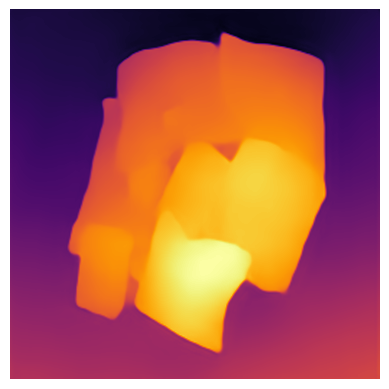

In [55]:
"""
MiDas computes relative inverse depth from a single image.
Source: https://pytorch.org/hub/intelisl_midas_v2/
"""
model_type = "MiDaS_small"  # DPT_Large - Large, DPT_Hybrid - Medium, MiDaS_small - Small
model = torch.hub.load("intel-isl/MiDaS", model_type).to(device).eval() # (lowest accuracy, highest inference speed)
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

input_batch = transform(canvas).to(device)

with torch.no_grad():
    prediction = model(input_batch)
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=canvas.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

depth_map = prediction.cpu().numpy()
plt.imshow(depth_map, cmap='inferno')
plt.axis('off')
plt.show()

Package 1: Angle from vertical=2.2°, Pick point=(475, 322)
Package 2: Angle from vertical=16.6°, Pick point=(679, 522)
Package 3: Angle from vertical=24.6°, Pick point=(730, 296)
Package 4: Angle from vertical=13.4°, Pick point=(527, 730)
Package 5: Angle from vertical=16.9°, Pick point=(358, 558)
Package 6: Angle from vertical=21.4°, Pick point=(273, 676)
Package 7: Angle from vertical=18.3°, Pick point=(533, 518)


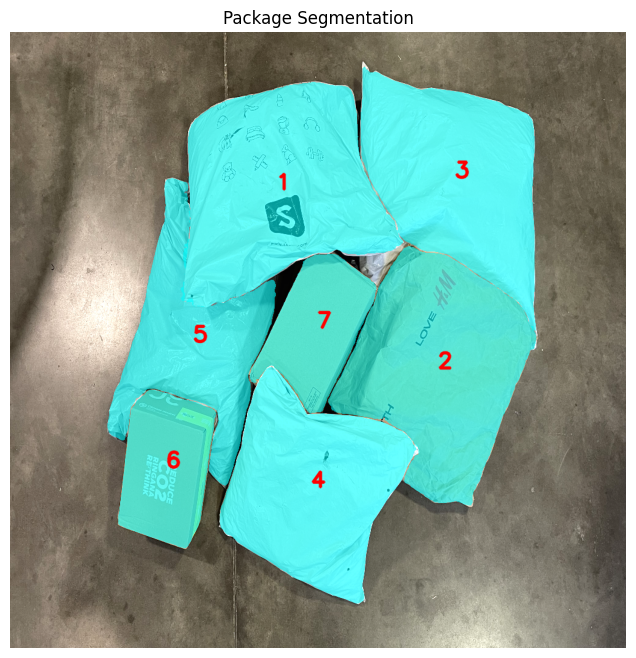

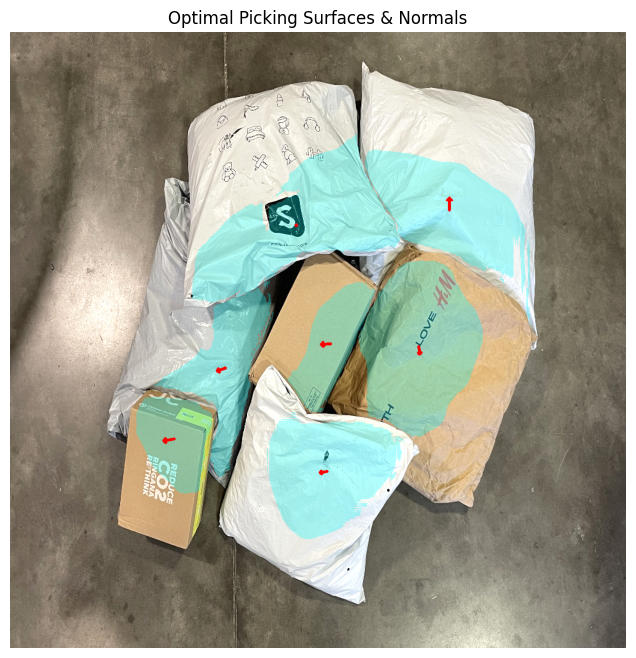

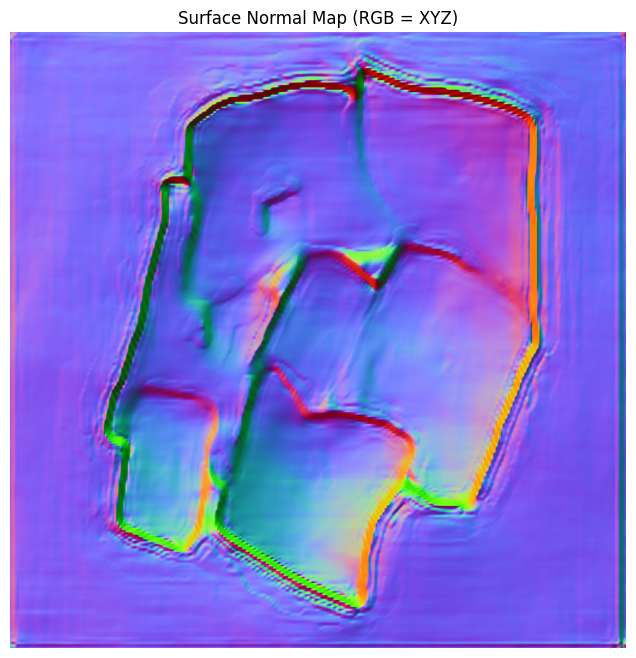

In [56]:
"""
To compute the normal map, I need to calculate the gradients of the depth map
Source of a final implementation: https://www.mdpi.com/2076-3417/14/21/9808

I had no time to finish the implementation.
I need to study more papers and more implementations to understand what an
efficient and accurate way to compute the best picking surface is. For the time being, this is acceptable.
"""
def compute_normals(depth_map, scale=1.0):
    """
    Compute surface normals using gradient-based method.
    Following equation (1-4) from the paper for surface differential geometry.
    """
    smoothed_depth = cv2.GaussianBlur(depth_map, (0, 0), sigmaX=1.0, sigmaY=1.0)
    grad_y, grad_x = np.gradient(smoothed_depth)
    # This follows the fundamental theorem of surface geometry
    normals_x = -grad_x * scale
    normals_y = -grad_y * scale
    normals_z = np.ones_like(grad_x)
    
    # Normalize to unit vectors
    magnitude = np.sqrt(normals_x**2 + normals_y**2 + normals_z**2)
    normals_x /= magnitude
    normals_y /= magnitude
    normals_z /= magnitude
    
    return normals_x, normals_y, normals_z

def find_optimal_picking_surface(mask, depth_map, normals_z):
    """
    Find optimal picking surface based on:
    1. Surface height (top regions)
    2. Surface planarity (high normal z-component indicates flat surface)
    3. Surface accessibility
    """
    depths = depth_map[mask]
    depth_threshold = np.percentile(depths, 50)  # Top 50% by height
    planarity_threshold = 0.7  # Surfaces close to horizontal (nz close to 1)
    
    # Combined criteria: high + flat
    high_region = (depth_map >= depth_threshold) & mask
    flat_region = (normals_z >= planarity_threshold) & mask
    optimal_region = high_region & flat_region
    
    # If optimal region too small, relax planarity constraint
    if np.sum(optimal_region) < 100:
        planarity_threshold = 0.5
        flat_region = (normals_z >= planarity_threshold) & mask
        optimal_region = high_region & flat_region
    
    return optimal_region

# Compute surface normals
normals_x, normals_y, normals_z = compute_normals(depth_map)
# Find optimal picking surfaces and visualize normals
result_canvas = image.copy()
arrow_length = 50
arrow_thickness = 3

for i, mask_info in enumerate(packages, start=1):
    mask = mask_info['segmentation']
    optimal_surface = find_optimal_picking_surface(mask, depth_map, normals_z)
    
    if np.any(optimal_surface):
        ys, xs = np.where(optimal_surface)
        if len(xs) > 0:
            cx, cy = int(xs.mean()), int(ys.mean())
            
            # Get normal vector at centroid
            nx = normals_x[cy, cx]
            ny = normals_y[cy, cx] 
            nz = normals_z[cy, cx]
            
            # Project 3D normal to 2D for visualization
            end_x = int(cx + nx * arrow_length)
            end_y = int(cy + ny * arrow_length)
            
            # Draw optimal surface region
            color = np.array([255, 255, 0], dtype=np.uint8)
            orig_pixels = result_canvas[optimal_surface].astype(np.float32)
            blended = orig_pixels * 0.7 + color * 0.3
            result_canvas[optimal_surface] = blended.astype(np.uint8)
            
            cv2.arrowedLine(result_canvas, (cx, cy), (end_x, end_y), 
                          (0, 0, 255), arrow_thickness, tipLength=0.3)
            angle_from_vertical = np.degrees(np.arccos(nz))
            
            # Return angle from vertical and pick point
            print(f"Package {i}: "
                  f"Angle from vertical={angle_from_vertical:.1f}°, "
                  f"Pick point=({cx}, {cy})")

plt.figure(figsize=(12,8))
plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
plt.title('Package Segmentation')
plt.axis('off')
plt.show()

plt.figure(figsize=(12,8))
plt.imshow(cv2.cvtColor(result_canvas, cv2.COLOR_BGR2RGB))
plt.title('Optimal Picking Surfaces & Normals')
plt.axis('off')
plt.show()

# Visualize surface normals as RGB image. Red: X component, Green: Y component, Blue: Z component
normal_visualization = np.zeros_like(image)
normal_visualization[..., 0] = ((normals_x + 1) * 127.5).astype(np.uint8)
normal_visualization[..., 1] = ((normals_y + 1) * 127.5).astype(np.uint8) 
normal_visualization[..., 2] = (normals_z * 255).astype(np.uint8)

plt.figure(figsize=(8,8))
plt.imshow(normal_visualization)
plt.title('Surface Normal Map (RGB = XYZ)')
plt.axis('off')
plt.show()